# Майнор по Анализу Данных, Группа ИАД-2
## Домашнее задание №1: визуализация, k-NN регрессия, кросс-валидация.

В этом задании мы рассмотрим задачу прогнозирования количества взятых в аренду велосипедов.

Файл [bike_sharing.csv](https://yadi.sk/d/n8iy_trO3EsUBa) содержит данные о 731 дне работы сервиса по аренде велосипедов. Про каждый день известны:

* instant: record index
* dteday : date
* season : season (1:springer, 2:summer, 3:fall, 4:winter)
* yr : year (0: 2011, 1:2012)
* mnth : month ( 1 to 12)
* holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius from 0 to 100.
- atemp: Normalized feeling temperature in Celsius from 0 to 100.
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rcParams['figure.figsize'] = (10,6)
plt.rc('font', family='Arial')

Для фиксации получаемых результатов.

In [2]:
RANDOM_SEED = 7

### 1. (0.25 балла) 
Откройте файл bike_sharing.csv, запишите в датафрейм df и выведите первые пять строк датафрейма.

Для нумерации используем 0 колонку исходной таблицы (в нее записаны номера экземпляров).

*Сразу же удалим признак **`instant`**, потому что он дублирует значения номеров экземпляров, попросту начиная отсчет с 1 (вместо 0).*

In [3]:
df = pd.read_csv(r"data/bike_sharing.csv", index_col=0)
df.drop('instant', axis=1, inplace=True)  # useless information
df.head()

dteday  season  yr  mnth  holiday  weekday  workingday  weathersit  \
0  2011-01-01       1   0     1        0        6           0           2   
1  2011-01-02       1   0     1        0        0           0           2   
2  2011-01-03       1   0     1        0        1           1           1   
3  2011-01-04       1   0     1        0        2           1           1   
4  2011-01-05       1   0     1        0        3           1           1   

      temp    atemp       hum  windspeed  casual  registered   cnt  
0  34.4167  36.3625  0.805833   0.160446     331         654   985  
1  36.3478  35.3739  0.696087   0.248539     131         670   801  
2  19.6364  18.9405  0.437273   0.248309     120        1229  1349  
3  20.0000  21.2122  0.590435   0.160296     108        1454  1562  
4  22.6957  22.9270  0.436957   0.186900      82        1518  1600

### 2. (1 балл) 
Постройте график среднего числа арендованных байков (cnt) по каждому месяцу. Не забудьте подписать оси координат. Убедитесь, что в летние месяцы велосипеды в прокат берут чаще.

Построим несколько графиков.

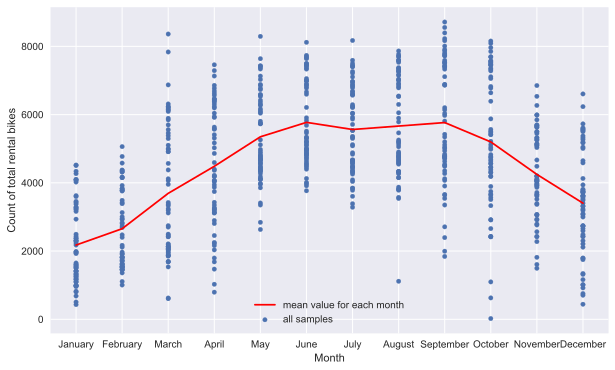

In [4]:
df.plot(x='mnth', y='cnt', kind='scatter')
plt.plot(
    df['mnth'].unique(), 
    df.loc[:, ['mnth', 'cnt']].groupby('mnth').mean()['cnt'], 
    c='r'
)

plt.xlabel("Month")
plt.ylabel("Count of total rental bikes")
plt.xticks(
    np.arange(1,13), 
    ('January', 'February', 'March', 'April', 'May', 'June',
     'July', 'August', 'September', 'October', 'November', 'December')
)
plt.legend(("mean value for each month", "all samples"));

Можно еще так (однако, в таком случае, оба графика *об одном*):

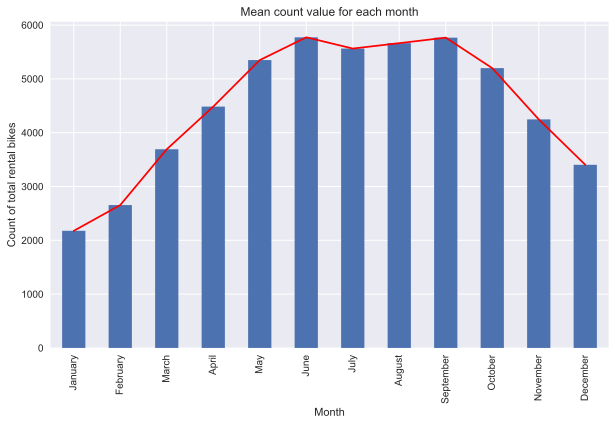

In [5]:
df.loc[:, ['mnth', 'cnt']].groupby('mnth').mean().plot(kind='bar')  # почему значение "bar" смещено к нулю?
plt.plot(
    df['mnth'].unique() - 1, 
    df.loc[:, ['mnth', 'cnt']].groupby('mnth').mean()['cnt'], 
    c='r'
)

plt.xlabel("Month")
plt.ylabel("Count of total rental bikes")
plt.xticks(
    np.arange(12), 
    ('January', 'February', 'March', 'April', 'May', 'June',
     'July', 'August', 'September', 'October', 'November', 'December')
)
plt.title("Mean count value for each month")
plt.legend(());

Исходя из графика, наиболее востребованы велосипеды в период ~~с 6 по 9 месяцы, что соответствует промежутку~~ Июнь-Сентябрь. Утверждение на счет летних прокатов выполняется.

### 3. (0.5 балла)
Постройте диаграмму рассеяния (scatter plot) с осями cnt и atemp, где точки — это объекты. Какой логичный вывод можно сделать по этому графику?

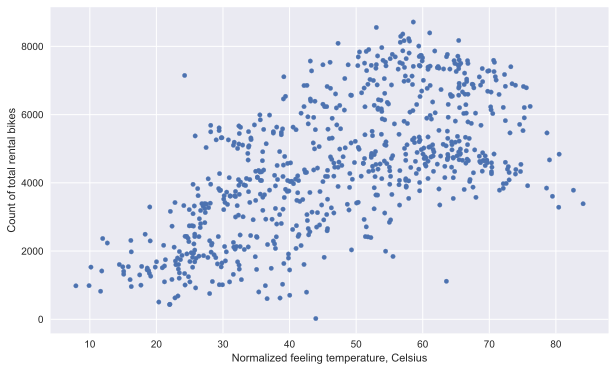

In [6]:
df.plot(x='atemp', y='cnt', kind='scatter')

plt.xlabel("Normalized feeling temperature, Celsius")
plt.ylabel("Count of total rental bikes");

Попытка сделать что-то более красивое.

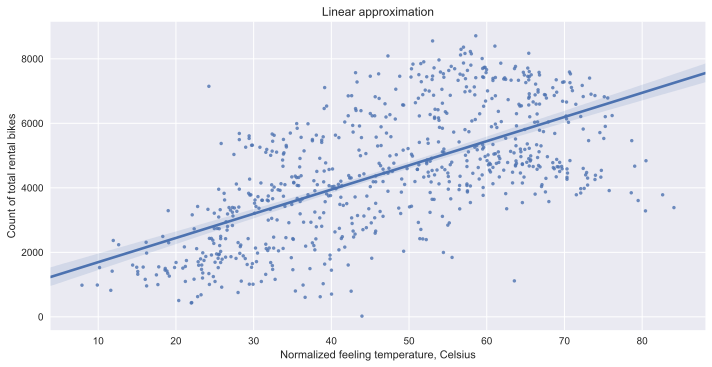

In [7]:
sns.lmplot(x='atemp', y='cnt', data=df, markers='.', aspect=2)

plt.xlabel("Normalized feeling temperature, Celsius")
plt.ylabel("Count of total rental bikes")
plt.title("Linear approximation");

**Вывод:** с повышением средней ощущаемой температуры возрастает потребность в аренде байков (судя по графику, зависимость не совсем линейная...).

Посмотрим нелинейное приближение.

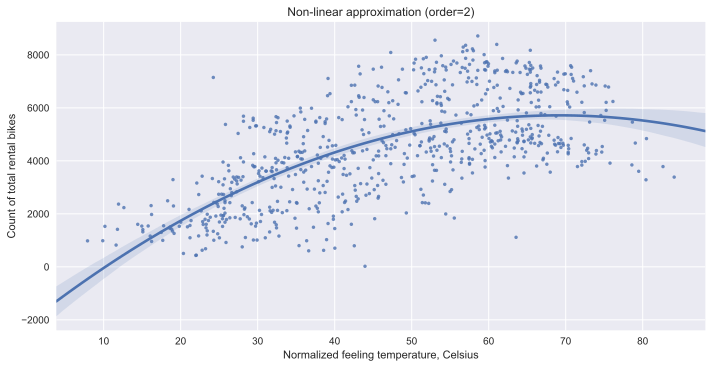

In [8]:
sns.lmplot(x='atemp', y='cnt', data=df, markers='.', aspect=2, order=2)

plt.xlabel("Normalized feeling temperature, Celsius")
plt.ylabel("Count of total rental bikes")
plt.title("Non-linear approximation (order=2)");

Вроде лучше...

### 4. (0.5 балла)
Преобразуйте небинарные категориальные признаки с помощью one-hot кодирования. Сделать это можно с помощью функции pd.get_dummies, указав нужные столбцы в параметре columns. Сколько признаков получилось после кодирования? И какой категориальный признак породил больше всего бинарных?

Категориальными в данной выборке являются признаки: 
* **`season`** (4 categories), 
* **`yr`** (2 categories), 
* **`mnth`** (12 categories),
* **`weekday`** (7 categories),
* **`weathersit`** (4 categories).

In [9]:
df_cat = pd.get_dummies(df, columns=['season', 'yr', 'mnth', 'weekday', 'weathersit'])
df_cat.head()

dteday  holiday  workingday     temp    atemp       hum  windspeed  \
0  2011-01-01        0           0  34.4167  36.3625  0.805833   0.160446   
1  2011-01-02        0           0  36.3478  35.3739  0.696087   0.248539   
2  2011-01-03        0           1  19.6364  18.9405  0.437273   0.248309   
3  2011-01-04        0           1  20.0000  21.2122  0.590435   0.160296   
4  2011-01-05        0           1  22.6957  22.9270  0.436957   0.186900   

   casual  registered   cnt      ...       weekday_0  weekday_1  weekday_2  \
0     331         654   985      ...               0          0          0   
1     131         670   801      ...               1          0          0   
2     120        1229  1349      ...               0          1          0   
3     108        1454  1562      ...               0          0          1   
4      82        1518  1600      ...               0          0          0   

   weekday_3  weekday_4  weekday_5  weekday_6  weathersit_1  weathersit_2  \
0          0          0          0          1             0             1   
1          0          0          0          0             0             1   
2          0          0          0          0             1             0   
3          0          0          0          0             1             0   
4          1          0          0          0             1             0   

   weathersit_3  
0             0  
1             0  
2             0  
3             0  
4             0  

[5 rows x 38 columns]

Теперь каждый образец описывается 38 признаками (было 15). <br/>
Больше всего бинарных признаков породил признак **`mnth`** (описывающий месяц $\implies$ 12 бинарных признаков).

**5. (0.25 балла)** Удалите столбцы instant, dteday, casual и registered. Предположите, почему мы удаляем эти признаки.

In [10]:
df_cat.drop(labels=['dteday', 'casual', 'registered'], axis=1, inplace=True)
df_cat.head()

holiday  workingday     temp    atemp       hum  windspeed   cnt  season_1  \
0        0           0  34.4167  36.3625  0.805833   0.160446   985         1   
1        0           0  36.3478  35.3739  0.696087   0.248539   801         1   
2        0           1  19.6364  18.9405  0.437273   0.248309  1349         1   
3        0           1  20.0000  21.2122  0.590435   0.160296  1562         1   
4        0           1  22.6957  22.9270  0.436957   0.186900  1600         1   

   season_2  season_3      ...       weekday_0  weekday_1  weekday_2  \
0         0         0      ...               0          0          0   
1         0         0      ...               1          0          0   
2         0         0      ...               0          1          0   
3         0         0      ...               0          0          1   
4         0         0      ...               0          0          0   

   weekday_3  weekday_4  weekday_5  weekday_6  weathersit_1  weathersit_2  \
0          0          0          0          1             0             1   
1          0          0          0          0             0             1   
2          0          0          0          0             1             0   
3          0          0          0          0             1             0   
4          1          0          0          0             1             0   

   weathersit_3  
0             0  
1             0  
2             0  
3             0  
4             0  

[5 rows x 35 columns]

> Признак **`instant`** был удален ранее (при загрузке выборки).

Удаляемые признаки не несут в себе дополнительной полезной информации:
* **`dteday`** - то же самое записано в признаках `yr` и `mnth`, в то время как день недели не важен в данном контексте (обобщение информации).
* **`casual`**, **`registered`** - вероятно, коррелируют с признаком `cnt`, так как `casual` + `registered` = `cnt`.

### 6. (0.5 балла)
Далее нашей целевой переменной будет количество арендованных велосипедов (cnt). Поэтому запишите cnt в переменную y и удалите из df. Затем в помощью функции train_test_split из sklearn.model_selection разделите выборку на обучающую и контрольную в отношении 7 к 3, создав переменные X_train, X_test, y_train, y_test.

Замечание 1: установите random_seed, чтобы генератор псевдослучайных чисел работал всегда одинаково.

In [11]:
y = df_cat.loc[:, ['cnt']]
X = df_cat.drop('cnt', axis=1)

y.head()
df_cat.head()

cnt
0   985
1   801
2  1349
3  1562
4  1600

holiday  workingday     temp    atemp       hum  windspeed   cnt  season_1  \
0        0           0  34.4167  36.3625  0.805833   0.160446   985         1   
1        0           0  36.3478  35.3739  0.696087   0.248539   801         1   
2        0           1  19.6364  18.9405  0.437273   0.248309  1349         1   
3        0           1  20.0000  21.2122  0.590435   0.160296  1562         1   
4        0           1  22.6957  22.9270  0.436957   0.186900  1600         1   

   season_2  season_3      ...       weekday_0  weekday_1  weekday_2  \
0         0         0      ...               0          0          0   
1         0         0      ...               1          0          0   
2         0         0      ...               0          1          0   
3         0         0      ...               0          0          1   
4         0         0      ...               0          0          0   

   weekday_3  weekday_4  weekday_5  weekday_6  weathersit_1  weathersit_2  \
0          0          0          0          1             0             1   
1          0          0          0          0             0             1   
2          0          0          0          0             1             0   
3          0          0          0          0             1             0   
4          1          0          0          0             1             0   

   weathersit_3  
0             0  
1             0  
2             0  
3             0  
4             0  

[5 rows x 35 columns]

Получение новых разбиений (масштабированных признаков).

In [12]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)
print(f"{X_train.shape}, {X_test.shape}, {y_train.shape}, {y_test.shape}")

(511, 34), (220, 34), (511, 1), (220, 1)


### 7. (1 балл)
Обучите алгоритм пяти ближайших соседей с евклидовой метрикой и оцените MAE на контрольной выборке.

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error  # для МАЕ

In [14]:
model_knr = KNeighborsRegressor(n_neighbors=5, metric='euclidean', weights='uniform', n_jobs=-1)  # модель для 5 ближайших соседей
model_knr.fit(X_train, y_train)  # обучение модели

y_hat_train = model_knr.predict(X_train)  # предсказания на обучающей выборке
y_hat = model_knr.predict(X_test);  # предсказания, сделанные по тестовой выборке

Оценка МАЕ ($\frac{1}{n} \sum_i |\hat{y}^{(i)}-y^{(i)}|$): 

In [15]:
error_train = mean_absolute_error(y_train, y_hat_train)  # ошибка на обучающей выборке
print(f"Mean absolute error on X_train: {error_train:.3f}")

error_test = mean_absolute_error(y_test, y_hat)  # ошибка на тестовой выборке
print(f"Mean absolute error on X_test: {error_test:.3f}")

Mean absolute error on X_train: 668.583
Mean absolute error on X_test: 909.575


**8. (0.5 балла)** Постройте диаграмму рассеяния (scatter plot), по одной оси отметив настоящее число аренд велосипедов, а по другой — предсказанное алгоритмом. Дополнительно на этом графике постройте прямую $y = x$. Чему соотстветствует отклонение от этой прямой?

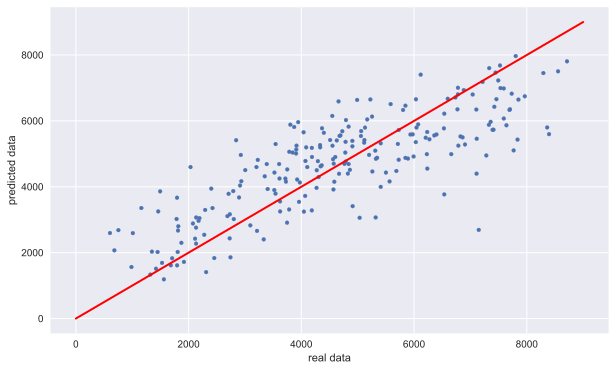

In [16]:
plt.scatter(x=y_test, y=y_hat, s=15)
plt.xlabel('real data')
plt.ylabel('predicted data')
cords=9000
plt.plot(np.linspace(0,cords,cords), np.linspace(0,cords,cords), color='r', linewidth=2);

Отклонение от красной прямой - величина несовпадения действительного результата с предсказанным (отклонение).

### 9. (1 балл)
Отмасштабируйте признаки, чтобы они принимали значения на $[0, 1]$.

Это можно сделать собственноручно с помощью операций pandas.

Иначе — можно использовать MinMaxScaler из sklearn.preprocessing — класс с методами fit и transform. 
Для этого:

* либо соедините X_train и X_test обратно в единый датафрейм, отмасштабируйте и разъедините обратно,
* либо отмасштабируйте df (без ответов) и разделите на обучающую и контрольную выборку, используя тот же random_seed.

На выходе метода transform получится numpy-массив, который нужно будет превратить обратно в датафрейм.

Не руками.

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()
scaler.fit(X)

X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)  # back to dataframe
X_scaled.head()

MinMaxScaler(copy=True, feature_range=(0, 1))

holiday  workingday      temp     atemp       hum  windspeed  season_1  \
0      0.0         0.0  0.355170  0.373517  0.828620   0.284606       1.0   
1      0.0         0.0  0.379232  0.360541  0.715771   0.466215       1.0   
2      0.0         1.0  0.171000  0.144830  0.449638   0.465740       1.0   
3      0.0         1.0  0.175530  0.174649  0.607131   0.284297       1.0   
4      0.0         1.0  0.209120  0.197158  0.449313   0.339143       1.0   

   season_2  season_3  season_4      ...       weekday_0  weekday_1  \
0       0.0       0.0       0.0      ...             0.0        0.0   
1       0.0       0.0       0.0      ...             1.0        0.0   
2       0.0       0.0       0.0      ...             0.0        1.0   
3       0.0       0.0       0.0      ...             0.0        0.0   
4       0.0       0.0       0.0      ...             0.0        0.0   

   weekday_2  weekday_3  weekday_4  weekday_5  weekday_6  weathersit_1  \
0        0.0        0.0        0.0        0.0        1.0           0.0   
1        0.0        0.0        0.0        0.0        0.0           0.0   
2        0.0        0.0        0.0        0.0        0.0           1.0   
3        1.0        0.0        0.0        0.0        0.0           1.0   
4        0.0        1.0        0.0        0.0        0.0           1.0   

   weathersit_2  weathersit_3  
0           1.0           0.0  
1           1.0           0.0  
2           0.0           0.0  
3           0.0           0.0  
4           0.0           0.0  

[5 rows x 34 columns]

Полученную отмасштабированную выборку снова разбиваем на подвыборки того же состава.

In [19]:
X_train_scaled, X_test_scaled = model_selection.train_test_split(X_scaled, test_size=0.3, random_state=RANDOM_SEED)
print(f"{X_train_scaled.shape}, {X_test_scaled.shape}")

(511, 34), (220, 34)


### 10. (0.5 балла)
Вновь обучите алгоритм пяти ближайших соседей с евклидовой метрикой и оцените MAE на контрольной выборке. Почему качество поменялось?

In [20]:
model_knr_scaled = KNeighborsRegressor(n_neighbors=5, metric='euclidean', weights='uniform', n_jobs=-1)
model_knr_scaled.fit(X_train_scaled, y_train)

y_hat_train_scaled = model_knr_scaled.predict(X_train_scaled)
y_hat_scaled = model_knr_scaled.predict(X_test_scaled)

error_train_scaled = mean_absolute_error(y_train, y_hat_train_scaled)
print(f"Mean absolute error on X_train_scaled: {error_train_scaled:.3f}")

error_test_scaled = mean_absolute_error(y_test, y_hat_scaled)
print(f"Mean absolute error on X_test_scaled: {error_test_scaled:.3f}");

Mean absolute error on X_train_scaled: 520.679
Mean absolute error on X_test_scaled: 684.323


Средняя абсолютная ошибка уменьшилась, поскольку в отмасштабированной выборке признаки вносят равноценные вклады в результат обучения модели.

### 11. (1.25 балла)
Используя класс KFold из sklearn.model_selection установите с помощью кросс-валидации на пяти фолдах, какой параметр weights лучше с точки зрения mean absolute error. 

Определение нескольких функций, используемых в качестве параметра **`weights`**.

In [21]:
# less - better
def reverse_exp(x):
    return 1/np.exp(x)

def sigmoid_deriv(x):
    return sigmoid(x)*(1 - sigmoid(x))


# more - better
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def distance_sqr(x):
    return x**2

In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer

scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)

С использованием функции `cross_val_score`.

In [23]:
kf = KFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
weights_types = {
    'uniform': 'uniform', 
    'distance': 'distance', 
    'sigmoid': sigmoid, 
    'reverse_exp': reverse_exp, 
    'sigmoid_deriv': sigmoid_deriv, 
    'distance_sqr': distance_sqr
}
scores = {}

for weights_type in weights_types.keys():
    scores[weights_type] = cross_val_score(
        KNeighborsRegressor(
            n_neighbors=5, 
            metric='euclidean', 
            weights=weights_types[weights_type],
            n_jobs=-1
        ),
        X_train_scaled,
        y_train,
        cv=kf,
        scoring=scorer
    )

for i, weights_type in enumerate(weights_types.keys()):
    print("{:20.20}:\t".format(weights_type), *scores[weights_type])

uniform             :	 -599.565048544 -653.731372549 -678.92745098 -734.952941176 -638.419607843
distance            :	 -606.995259357 -597.731009519 -653.876737568 -712.642328922 -632.612120026
sigmoid             :	 -605.63798928 -659.439781442 -681.95895147 -740.28160928 -646.354522142
reverse_exp         :	 -594.528659292 -630.619972361 -666.085096534 -722.021227141 -631.049957241
sigmoid_deriv       :	 -593.209098136 -648.16773193 -675.49594059 -732.297342819 -631.307957324
distance_sqr        :	 -652.475748729 -675.407239089 -697.737131808 -750.426169666 -681.991266589


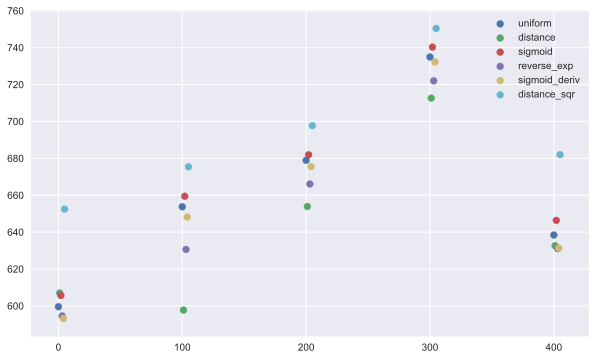

In [24]:
for i, weights_type in enumerate(weights_types.keys()):
    # pretty foolish heuristic: shift x-coordinates by 1 for each iteration to improve readability
    plt.scatter(np.arange(i, 500 + i, 100), -np.array(scores[weights_type]))
plt.legend(('uniform', 'distance', 'sigmoid', 'reverse_exp', 'sigmoid_deriv', 'distance_sqr'));

Лучшим будем считать параметр **`weights`** с наименьшей суммарной ошибкой.

In [25]:
total_score = []
mean_score = []
for weights_type in weights_types.keys():
    print("{:20.20}:\t".format(weights_type), sum(-scores[weights_type]), np.mean(-scores[weights_type]))
    total_score.append(sum(-scores[weights_type]))
    mean_score.append(np.mean(-scores[weights_type]))
print(f"Minimal total error:\t{min(total_score)}\nMinimal mean:\t{min(mean_score)}")

uniform             :	 3305.59642109 661.119284219
distance            :	 3203.85745539 640.771491078
sigmoid             :	 3333.67285361 666.734570723
reverse_exp         :	 3244.30491257 648.860982514
sigmoid_deriv       :	 3280.4780708 656.09561416
distance_sqr        :	 3458.03755588 691.607511176
Minimal total error:	3203.857455391976
Minimal mean:	640.7714910783952


**Вывод:** <br/>
Из стандартных возможных значений, с точки зрения МАЕ, **`'distance'`** ошибается меньше. <br/>
Из всех испытанных параметров, наименьшая ошибка также у **`distance`** (согласно МАЕ).

**Ручная проверка полученного результата.**

In [26]:
def count_knn_kf_error(X_train, y_train, X_test, y_test, neighbors=5, metric='euclidean', weigths='uniform'):
    model_knr = KNeighborsRegressor(n_neighbors=neighbors, metric=metric, weights=weigths)
    model_knr.fit(X_train, y_train)

    y_hat_train = model_knr.predict(X_train)
    y_hat = model_knr.predict(X_test)
    
    return [mean_absolute_error(y_train, y_hat_train), mean_absolute_error(y_test, y_hat)]

In [27]:
errors = {
    'uniform': [],
    'distance': [],
    'reverse_exp': [],
    'sigmoid': [],
    'sigmoid_deriv': [],
    'distance_sqr': []
}

for train_index, test_index in kf.split(X_scaled, y):
    X_kf_train, X_kf_test = X_scaled.ix[train_index], X_scaled.ix[test_index]
    y_kf_train, y_kf_test = y.ix[train_index], y.ix[test_index]
    for weights_type in weights_types.keys():
        errors[weights_type].append(
            count_knn_kf_error(
                X_kf_train, 
                y_kf_train, 
                X_kf_test, 
                y_kf_test, 
                weigths=weights_types[weights_type]
            )[1]  # only test scores
        )

for i, weights_type in enumerate(weights_types.keys()):
    print("{:20.20}:\t".format(weights_type), *errors[weights_type])

uniform             :	 646.971428571 679.791780822 601.594520548 709.391780822 604.867123288
distance            :	 644.937594238 666.125067927 597.033717496 705.805005316 621.963758687
sigmoid             :	 650.527489865 684.250800439 606.417665878 718.373038595 607.23477876
reverse_exp         :	 645.287966577 678.048256102 596.990789775 706.272356245 615.373086629
sigmoid_deriv       :	 643.730462975 679.53189103 598.592261815 707.031201618 606.910985282
distance_sqr        :	 683.495362307 721.033463767 647.397334618 768.693156338 627.522097605


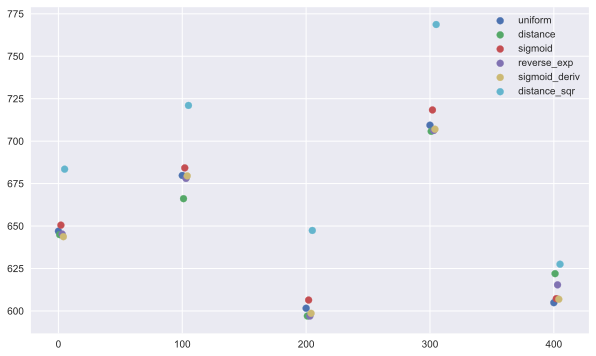

In [28]:
for i, weights_type in enumerate(weights_types.keys()):
    plt.scatter(np.arange(i, 500 + i, 100), np.array(errors[weights_type]))
plt.legend(('uniform', 'distance', 'sigmoid', 'reverse_exp', 'sigmoid_deriv', 'distance_sqr'));

In [29]:
total_errors = []
mean_errors = []
for weights_type in weights_types.keys():
    print("{:20.20}:\t".format(weights_type), sum(errors[weights_type]), np.mean(errors[weights_type]))
    total_errors.append(sum(errors[weights_type]))
    mean_errors.append(np.mean(errors[weights_type]))
print(f"Minimal total error:\t{min(total_errors)}\nMinimal mean:\t{min(mean_errors)}")

uniform             :	 3242.61663405 648.52332681
distance            :	 3235.86514366 647.173028733
sigmoid             :	 3266.80377354 653.360754707
reverse_exp         :	 3241.97245533 648.394491066
sigmoid_deriv       :	 3235.79680272 647.159360544
distance_sqr        :	 3448.14141463 689.628282927
Minimal total error:	3235.7968027191882
Minimal mean:	647.1593605438377


Подтверждение: лучшим параметром (*из стандартных*) является **`distance`**.

**12. (2.5 балла)** С помощью GridSearchCV из sklearn.model_selection на пяти фолдах выберите лучшее значение $k$ от 1 до 50. Постройте график MAE на кросс-валидации в зависимости от $k$. 

Замечание: Передать нужную метрику качества для GridSearchCV можно через параметр scoring, но не всё так просто. Из метрики качества нужно сделать «scorer» c помощью функции sklearn.metrics.make_scorer, не забыв указать нужное значение greater_is_better.

*К сожалению, у меня не получилось установить параметр `weights` в значение произвольной функци (`reverse_exp`, <...>) - все просто зависало (пол часа без результатов).*

In [30]:
from sklearn.model_selection import GridSearchCV

In [31]:
x = np.arange(50) + 1

cv_grid = GridSearchCV(
    estimator=KNeighborsRegressor(metric='euclidean', weights='distance', n_jobs=-1), 
    param_grid={
        'n_neighbors': x
    }, 
    scoring=scorer, 
    cv=kf, 
    n_jobs=-1
)

cv_grid.fit(X_train_scaled, y_train);

# cv_grid.cv_results_

Ошибка на тренировочных подвыборках нас не интересует. Рассмотрим ошибку на тестовых выборках (для различных фолдов).

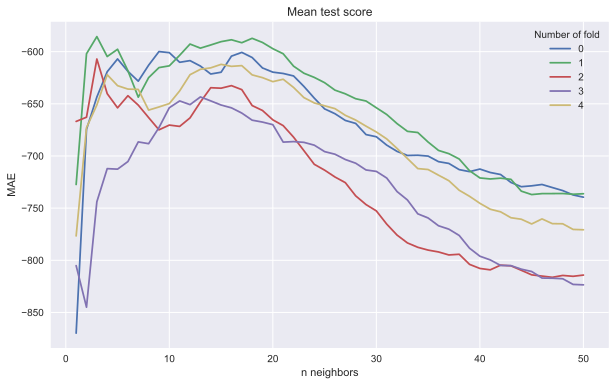

In [32]:
for i in range(cv_grid.cv.n_splits):
    plt.plot(x, cv_grid.cv_results_["split{}_test_score".format(i)])
plt.legend((0, 1, 2, 3, 4), title="Number of fold")
plt.xlabel('n neighbors')
plt.ylabel('MAE')
plt.title('Mean test score');

Нас интересует минимальная по абсолютному значению и средняя ошибка. Для этого усредним показатели всех фолдов.

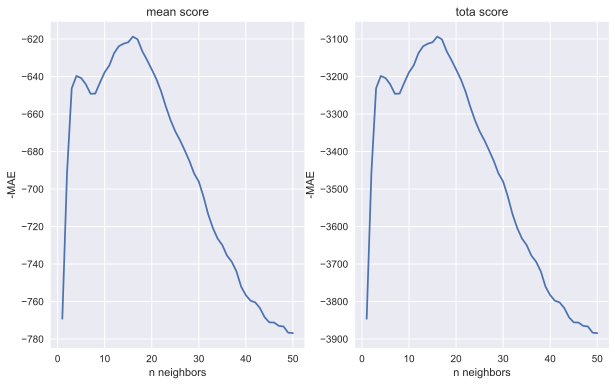

In [33]:
scores_cv = []
for i in range(cv_grid.cv.n_splits):
    scores_cv.append(cv_grid.cv_results_["split{}_test_score".format(i)])
scores_cv = np.array(scores_cv)

fig, ax = plt.subplots(1, 2)

mean_score_cv = np.array([np.mean(fold) for fold in scores_cv.T])
ax[0].plot(x, mean_score_cv)

total_score_cv = sum(scores_cv)
ax[1].plot(x, total_score_cv)

for i in range(2):
    ax[i].set_xlabel('n neighbors')
    ax[i].set_ylabel('-MAE')
ax[0].set_title("mean score")
ax[1].set_title("tota score");

Искомое значение - максимум из полученных значений.

In [34]:
print(f"(total) k = {total_score_cv.argmax() + 1}: {total_score_cv[total_score_cv.argmax()]:.3f}")
print(f"(mean) k = {mean_score_cv.argmax() + 1}: {mean_score_cv[mean_score_cv.argmax()]:.3f}")

(total) k = 16: -3093.477
(mean) k = 16: -618.695


**13. (0.25 балла)** Посчитайте качество итоговой модели на контрольной выборке. 

Обучим модель с полученными параметрами.

In [35]:
model_final = KNeighborsRegressor(n_neighbors=mean_score_cv.argmax() + 1, metric='euclidean', weights='distance', n_jobs=-1)
model_final.fit(X_train_scaled, y_train)

y_hat_final = model_final.predict(X_test_scaled)

error_test_final = mean_absolute_error(y_test, y_hat_final)
print(error_test_final);

646.067485029


Как и следовало ожидать, качество предсказаний улучшилось.